# <center>Determining Hateful Twitter Users</center>
### <center>Caroline Horsch and Edmund Horsch</center>
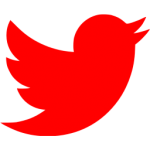

### What are hateful users?
Social media is a great way for people to learn, connect, and support each other. Unfortunately, this positive environment is ruined when users contribute hateful content. Twitter especially is a website where hate speech has become a huge problem. On twitter's <a href = "https://help.twitter.com/en/rules-and-policies/hateful-conduct-policy">Hateful Conduct Policy</a> webpage, they define the types of conduct and content that are considered "hateful".
>__Hateful conduct:__ 
You may not promote violence against or directly attack or threaten other people on the basis of race, ethnicity, national origin, sexual orientation, gender, gender identity, religious affiliation, age, disability, or serious disease. We also do not allow accounts whose primary purpose is inciting harm towards others on the basis of these categories.

>__Hateful imagery and display names:__
You may not use hateful images or symbols in your profile image or profile header. You also may not use your username, display name, or profile bio to engage in abusive behavior, such as targeted harassment or expressing hate towards a person, group, or protected category. 

### Why do we want to identify hateful users?
Over the years, twitter has been implementing new rules and increasing moderation in order to reduce abusive interactions on their website. One effective way to reduce hate speech is to ban or block hateful users, so that they can no longer contribute hurtful content. If we can correctly identify which users are hateful, we can stop those users from posting to the website, and eliminate abusive content on twitter. 

### How is Data Science useful in identifying hateful users?
After collecting data from twitter about its users, we will be able to analyze this data and search for patterns that suggest a user is abusive. In the end, we will create a model that will take in information from twitter and tell us who is likely to be a hateful user who needs to be removed.
In this tutorial we will be following the data science life cycle in order to perform our task of identifying hateful users. The data science life cycle goes as follows:
<img src = "DataLifecycle.png">
<a hfref = "http://www.cs.umd.edu/class/summer2019/cmsc320/files/Lec01.pdf">Image Source</a>

### Technology Introduction
In this tutorial we are going to be using the following languages, libraries, and technologies. If you want more information on any of these before beginning, follow the link and read up!
<ul>
    <li> Python
    <li> pandas
    <li> numpy
    <li> matplotlib
    <li> sklearn
</ul>

In [179]:
import pandas as pd
import re
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Data Collection

The data we are using is a dataset found on kaggle, a website where users can upload datasets for public use. The dataset can be found and downloaded from <a href = "https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter">here.</a> 

#### Data Size
This dataset contains information for over 100,000 users, with 5,000 of those users being labelled as either hateful or normal. The label of the remaining users is unknown. The size of the dataset is 100386 rows (or observations, or users) and 1039 columns (or attributes, or predictors).

#### Data Content
For each of the users, the dataset contains information about their activity (followers, folowees, retweets, likes, etc.), their network (who they are connected to, centrality measurements, etc.), and their content (what kinds of things they are writing about). 

Let's get started! To begin working with the data, download the data set from the kaggle link above and read it into a pandas dataframe. Then, to get a feel for what kind of information we have, let's print a list of all of the attributes.

In [2]:
data = pd.read_csv('hateful-users-on-twitter/users_neighborhood_anon.csv')

In [3]:
data.columns

Index(['user_id', 'hate', 'hate_neigh', 'normal_neigh', 'statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness',
       ...
       'c_feminine_empath', 'c_medieval_empath', 'c_journalism_empath',
       'c_farming_empath', 'c_plant_empath', 'c_shopping_empath',
       'c_ship_empath', 'c_religion_empath', 'c_tourism_empath',
       'c_power_empath'],
      dtype='object', length=1039)

## Data Processing
#### Glove Vectors
Now that we have our data and unserstand a little bit about it, we want to clean it up to make it easier to read and understand. We won't be using the 'glove' attributes, so let's delete those columns now. This considerably reduces the number of columns we much evaluate from over 1,000 to 439. 

In [4]:
for col in data.columns:
#     if re.match(r"^.*glove$", col):
#         del data[col]
data.columns

Index(['user_id', 'hate', 'hate_neigh', 'normal_neigh', 'statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness',
       ...
       'c_feminine_empath', 'c_medieval_empath', 'c_journalism_empath',
       'c_farming_empath', 'c_plant_empath', 'c_shopping_empath',
       'c_ship_empath', 'c_religion_empath', 'c_tourism_empath',
       'c_power_empath'],
      dtype='object', length=439)

#### Empath Attributes
Now let's try to pick out the attributes that seem to have the biggest gap between normal and hateful users. Let's begin with the empath attributes. The empath values represent what percentage of words from the user's last 200 tweets fell into the different categories. An example would be 'feminine_empath' gives the percentage of words from the user's last 200 tweets that are considered feminine.

#### Picking Empath Attributes
To find the significant attributes, I want to look for the attributes that are at least 1.5 times higher or lower on average for hateful users when compared to normal users. To do this, I will just loop through each attribute, check that  it is an empath attribute using <a href = "https://en.wikipedia.org/wiki/Regular_expression">regular expressions</a>, and calculate the means. After this operation I'm left with a list of the attributes where hateful and normal users differ the most. 

In [442]:
#Find the significant atributes 
significant_atts = []
for att in data.columns:
    if re.match(r"^.*_empath$", att):
        a = data[att][data['hate']=='hateful'].mean()
        b = data[att][data['hate']=='normal'].mean()
        if(a/b > 2 or b/a > 2):
            significant_atts.append(att)
len(significant_atts)

8

This is still a bit large. Let's make a tighter restriction: 2 times higher or lower than normal users. 

In [553]:
#tighten the significance threshold
#Find the very significant atributes 
very_significant_atts = []
for att in data.columns:
    if re.match(r"^.*_empath$", att):
        a = data[att][data['hate']=='hateful'].mean()
        b = data[att][data['hate']!='hateful'].mean()
        if(a/b > 2 or b/a > 2):
            very_significant_atts.append((att, a, b))
len(very_significant_atts)

8

Now we have 8 attributes that we have determined are very significant. Let's look at how they 

('computer_empath', 0.0004284115620196878, 0.00019206037546321017)
('violence_empath', 0.0003163252231108762, 0.0006905921940122932)
('furniture_empath', 0.0052040041733445825, 0.0024006835324307456)
('anger_empath', 0.0013145051527790282, 0.002778448025670528)
('c_computer_empath', 0.0004119867988506608, 0.00019667219087109248)
('c_furniture_empath', 0.004854337105147649, 0.0023564964361726445)
('c_anger_empath', 0.0013751741999616844, 0.002794049211134578)
('c_violence_empath', 0.0003433764393163562, 0.0007131925312029089)


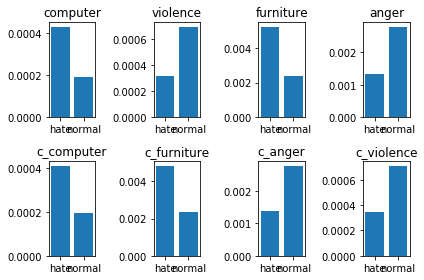

In [554]:
#Plot the very significant attributes
fig, ax = plt.subplots(2, 4)
#plt.suptitle("Language Categories")
for i, att in enumerate(very_significant_atts):
    print(att)
    ax[i//4] [i%4].bar(['hate', 'normal'],[att[1], att[2]])
    ax[i//4] [i%4].set_title(att[0][0:-7])
    plt.tight_layout()
plt.tight_layout()

Let's look at the distribution of hateful and normal users when looking at a few different attributes. First let's consider followers and follows.

Normal Median =  311.0728008745824
Hateful Median =  70.69414884554163


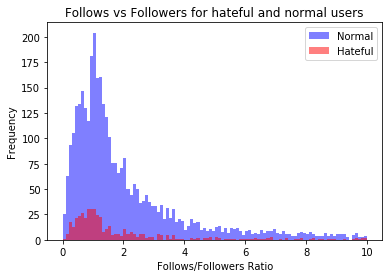

In [97]:
ratios_hateful = pd.DataFrame()
ratios_hateful['follows'] = data['followees_count'][data['hate'] == 'hateful']
ratios_hateful['followers'] = data['followers_count'][data['hate'] == 'hateful']
ratios_hateful['ratio'] = ratios_hateful['followers']/ratios_hateful['follows']

ratios_normal = pd.DataFrame()
ratios_normal['follows'] = data['followees_count'][data['hate'] == 'normal']
ratios_normal['followers'] = data['followers_count'][data['hate'] == 'normal']
ratios_normal['ratio'] = ratios_normal['followers']/ratios_normal['follows']

#print(ratios_normal)
plt.hist(ratios_normal['ratio'][ratios_normal['follows'] != 0], bins = 100, color = 'blue', range = (0, 10), alpha = 0.5)
plt.hist(ratios_hateful['ratio'][ratios_hateful['follows'] != 0], bins = 100, color = 'red', range = (0, 10), alpha = 0.5)
plt.xlabel("Follows/Followers Ratio")
plt.ylabel("Frequency")
plt.title("Follows vs Followers for hateful and normal users")
print("Normal Median = ",ratios_normal['ratio'][ratios_normal['follows'] != 0].mean())
print("Hateful Median = ",ratios_hateful['ratio'][ratios_hateful['follows'] != 0].mean())
plt.legend(['Normal', 'Hateful'])

In [443]:
params = significant_atts
params.append('followees_count')
params.append('followers_count')
params.append('hate')

In [444]:
df = data[params][data['hate'] != 'other']
df = df.dropna()
train, test = sklearn.model_selection.train_test_split(df, test_size = 0.05)

y_train = train['hate']
x_train = train.drop('hate', axis = 1)

y_test = test['hate']
x_test = test.drop('hate', axis = 1)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [445]:
a = log_reg.predict(x_test)
print(log_reg.score(x_test, y_test))
a[a != 'normal']

0.8811475409836066


array([], dtype=object)

In [263]:
svm = SVC(gamma='auto')
svm.fit(x_train, y_train)
print(svm.score(x_test, y_test))
a = svm.predict(x_test)
a[a != 'normal']

0.9098360655737705


array([], dtype=object)

In [264]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)
a = knn.predict(x_test)
print(a[a != 'normal'])
print(score)

['hateful' 'hateful' 'hateful' 'hateful' 'hateful' 'hateful']
0.8852459016393442


In [269]:
import networkx as nx

graph = nx.read_graphml('users_clean.graphml')

Hateful neighbors:  1
Normal neighbors:  2


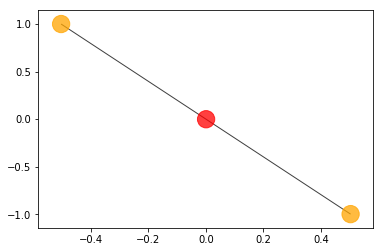

Hateful neighbors:  11
Normal neighbors:  2


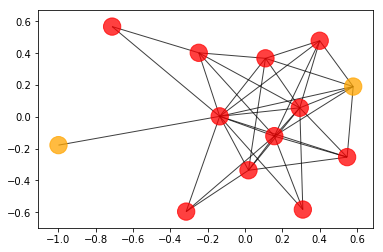

Hateful neighbors:  1
Normal neighbors:  0


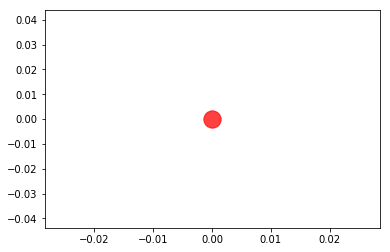

Hateful neighbors:  18
Normal neighbors:  3


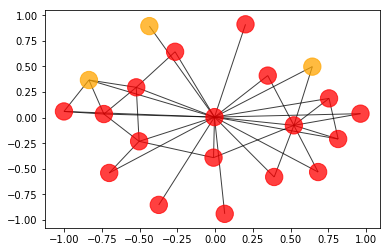

Hateful neighbors:  1
Normal neighbors:  2


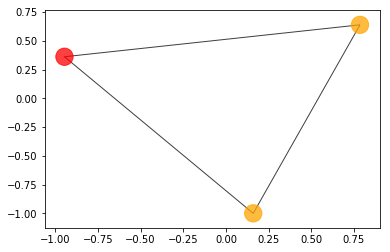

In [270]:
g = graph
nx.number_of_nodes(g)

## draw for hateful users:
for i in data['user_id'][data['hate'] == 'hateful'][20:25]:
    
    plt.figure(i)
    
    num_hateful = 0
    num_normal = 0
    
    g1 = nx.Graph()
    origin_node = str(data.iloc[i]['user_id'])
    
    node_it = nx.neighbors(graph, origin_node)
    
    # nodes/colors:
    colors = []
    nodes = []
    for node in node_it:
        if data.iloc[int(node)]['hate'] == "hateful":
            colors.append('red')
            nodes.append(node)
            num_hateful += 1
        elif data.iloc[int(node)]['hate'] == "normal":
            colors.append('orange')
            nodes.append(node)
            num_normal += 1
            
    
    # edges: 
    edges = []
    for node in nodes:
        arr1 = g.in_edges(node)
        arr2 = g.out_edges(node)
        for (i, o) in arr1:
            if (i in nodes) and (o in nodes):
                edges.append((i, o))
        for (i, o) in arr2:
            if (i in nodes) and (o in nodes):
                edges.append((i, o))
    
    g1.add_nodes_from(nodes)
    g1.add_edges_from(edges)
    
    
    print("Hateful neighbors: ", num_hateful)
    print("Normal neighbors: ", num_normal)
    nx.draw_networkx(g1, node_list=nodes, node_color=colors, with_labels=False, alpha=0.75)
    plt.show()

In [271]:
# add a column for "hateful neighbors" and "normal neighbors"
df = data[data['hate'] != "other"]

hateful_neighbors = []
normal_neighbors = []
ratio = []


for i in df['user_id']:
    
    num_hateful = 0
    num_normal = 0
    
    g1 = nx.Graph()
    origin_node = str(data.iloc[i]['user_id'])
    
    node_it = nx.neighbors(graph, origin_node)
    
    # nodes:
    nodes = []
    for node in node_it:
        if data.iloc[int(node)]['hate'] == "hateful":
            num_hateful += 1
        elif data.iloc[int(node)]['hate'] == "normal":
            num_normal += 1
    hateful_neighbors.append(num_hateful)
    normal_neighbors.append(num_normal)

In [280]:
print(data.shape)
data = data[data['hate'] != 'other']
data['hateful_neighbors'] = hateful_neighbors
data['normal_neighbors'] = normal_neighbors

(100386, 439)


C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [446]:
params.append('hateful_neighbors')
params.append('normal_neighbors')

In [504]:
df = data[params][data['hate'] != 'other']
df = df.dropna()
train, test = sklearn.model_selection.train_test_split(df, test_size = 0.05)

y_train = train['hate']
x_train = train.drop('hate', axis = 1)

y_test = test['hate']
x_test = test.drop('hate', axis = 1)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
df.columns

Index(['computer_empath', 'violence_empath', 'furniture_empath',
       'anger_empath', 'c_computer_empath', 'c_furniture_empath',
       'c_anger_empath', 'c_violence_empath', 'followees_count',
       'followers_count', 'hate', 'hateful_neighbors', 'normal_neighbors'],
      dtype='object')

Accuracy:  0.9508196721311475


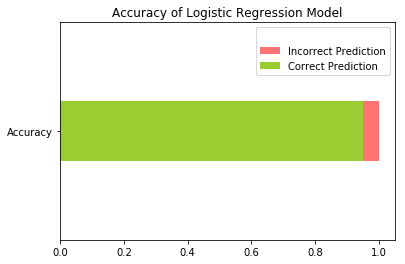

In [531]:
print("Accuracy: ", log_reg.score(x_test, y_test))
plt.barh(['Accuracy'], 1, color = 'white', alpha = 0.55, height = 1)
plt.barh(['Accuracy'], 1, color = 'red', alpha = 0.55, height = 0.3)
plt.barh(['Accuracy'], log_reg.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = 0.3)
plt.title("Accuracy of Logistic Regression Model")
plt.legend(["",'Incorrect Prediction', 'Correct Prediction'])

In [532]:
svm = SVC(gamma='auto')
svm.fit(x_train, y_train)
print(svm.score(x_test, y_test))

0.9057377049180327


In [533]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)
print(score)

0.8852459016393442


Accuracy:  0.9508196721311475


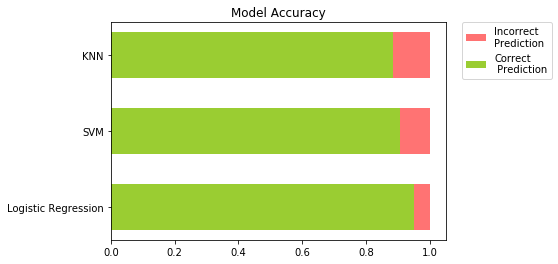

In [558]:
print("Accuracy: ", log_reg.score(x_test, y_test))
h = 0.6
c = 'red'
#plt.barh(['Accuracy'], 1, color = 'white', alpha = 0.55, height = 1)
plt.barh(['Logistic Regression'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['Logistic Regression'], log_reg.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = h)
plt.barh(['SVM'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['SVM'], svm.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = h)
plt.barh(['KNN'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['KNN'], knn.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = h)
plt.title("Model Accuracy")
plt.legend(['Incorrect\nPrediction', 'Correct\n Prediction'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)